# Adding EV component to demand profiles

We have taken EV profiles from the NREL Electrification Futures Studies.
https://data.nrel.gov/submissions/126
Specifically, we are using the "EFSLoadProfile_High_Rapid.zip" file which produces a 2.5 GB file seen in the cells below.

Mai, Trieu, Paige Jadun, Jeffrey Logan, Colin McMillan, Matteo Muratori, Daniel Steinberg, Laura Vimmerstedt, Ryan Jones, Benjamin Haley, and Brent Nelson. 2018. Electrification Futures Study: Scenarios of Electric Technology Adoption and Power Consumption for the United States. National Renewable Energy Laboratory. NREL/TP-6A20-71500. https://doi.org/10.2172/1459351.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl

import calendar
from datetime import date, time, datetime, timedelta

In [2]:
df1 = pd.read_csv('EFSLoadProfile_High_Rapid.csv')
print(len(df1.index)) 

35320320


In [3]:
df1.head()

,Electrification,TechnologyAdvancement,Year,LocalHourID,State,Sector,Subsector,LoadMW
0,High,Rapid,2018,1,AL,Commercial,other,2192.636058
1,High,Rapid,2018,1,AL,Commercial,space heating and cooling,78.106400
2,High,Rapid,2018,1,AL,Commercial,water heating,10.626500
3,High,Rapid,2018,1,AL,Industrial,machine drives,979.958000
4,High,Rapid,2018,1,AL,Industrial,other,1277.307744


In [4]:
print(df1['Year'].unique())
print(df1['Sector'].unique())

[2018 2020 2024 2030 2040 2050]
['Commercial' 'Industrial' 'Residential' 'Transportation']


In [5]:
df = df1.loc[ df1['Sector'] == 'Transportation']
print(df['Subsector'].unique())
df = df.loc[ df['Subsector'] != 'other']
print(df['Subsector'].unique())

['heavy-duty trucks' 'light-duty vehicles' 'medium-duty trucks' 'other']
['heavy-duty trucks' 'light-duty vehicles' 'medium-duty trucks']


In [6]:
df = df.loc[ df['Year'] == 2050 ]

ERCOT ['TX']
['TX']
26280
8760.0


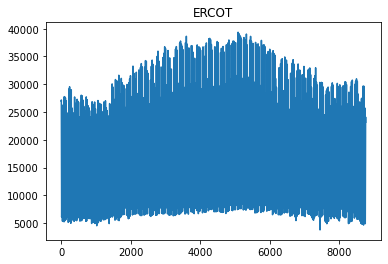

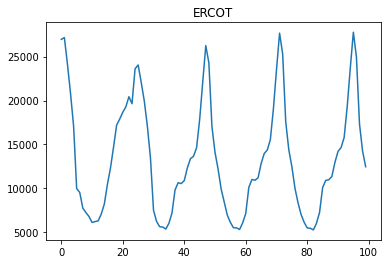

NYISO ['NY']
['NY']
26280
8760.0


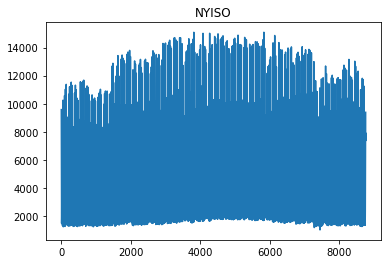

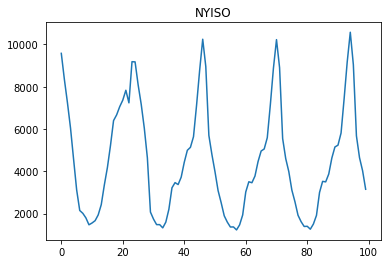

PJM ['OH', 'WV', 'PA', 'NJ', 'DE', 'MD', 'VA']
['DE' 'MD' 'NJ' 'OH' 'PA' 'VA' 'WV']
183960
8760.0


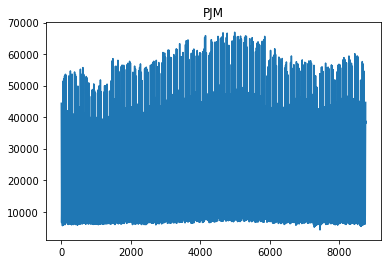

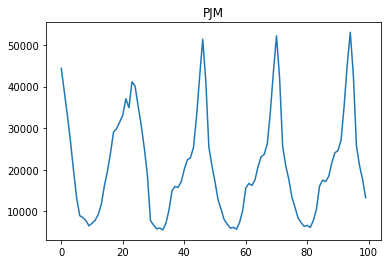

FR ['OH', 'WV', 'PA', 'NJ', 'DE', 'MD', 'VA']
['DE' 'MD' 'NJ' 'OH' 'PA' 'VA' 'WV']
183960
8760.0


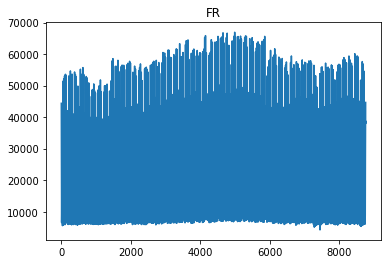

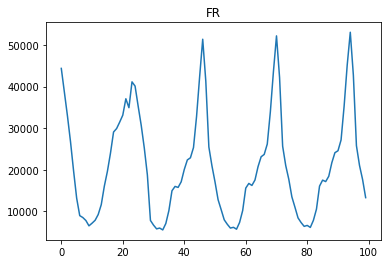

In [7]:
adj = { # Winter timezone, example, Texas is UTC-6, so we have +6 to adjust all hours to align w/ UTC
    'ERCOT' : 6, # UTC -6
    'NYISO' : 5, # UTC -5
    'PJM' : 5, # UTC -5, go with east coast
    'FR' : 5, # real is UTC +1, but we are taking the PJM profile and shifting to UTC
}

def per_region(df, name, states):
    df2 = df.loc[ df['State'].isin(states)]
    print(df2['State'].unique())
    print(len(df2.index))
    print(len(df2.index)/(3*len(df2['State'].unique())))

    demand = np.zeros(8760)
    for i in range(8760):
        tmp = df2.loc[ df2['LocalHourID'] == i+1] # Hours are "1" indexed
        #print(i, (i+adj[name]), (i+adj[name])%8760)
        demand[(i+adj[name])%8760] = np.sum(tmp['LoadMW'])
    plt.plot(demand)
    plt.title(name)
    plt.show()
    plt.plot(demand[:100])
    plt.title(name)
    plt.show()
    return np.array(demand)

m = {
    'ERCOT' : ['TX',],
    'NYISO' : ['NY',],
    'PJM' : ['OH', 'WV', 'PA', 'NJ', 'DE', 'MD', 'VA'],
    'FR' : ['OH', 'WV', 'PA', 'NJ', 'DE', 'MD', 'VA']
}
ds = {}
for k, v in m.items():
    print(k, v)
    ds[k] = per_region(df, k, v)

In [8]:
# From helpers.py
def return_file_info_map(region):
    #assert(region in ['CONUS', 'ERCOT', 'NYISO', 'TEXAS'])

    info_map = { # region : # f_path, header rows
        'ERCOT': { # New files June 2020
            'demand': ['data/ERCOT_mem_1998-2019.csv', 0, 'demand (MW)', 'year'],
            'wind': ['data/20200624v4_ERCO_2018_mthd3_1990-2019_wind.csv', 0, 'w_cfs', 'year'],
            'solar': ['data/20200624v4_ERCO_2018_mthd3_1990-2019_solar.csv', 0, 's_cfs', 'year'],
            'temp': ['data/20210113v5_ERCO_2018_mthd1_2000-2019_temp.csv',],
            'years' : [y for y in range(2003, 2020)],
            'to_local' : -6, # CST time = UTC-6
        },
        'NYISO': { # New files June 2020
            'demand': ['data/NYISO_demand_unnormalized.csv', 0, 'demand (MW)', 'year'],
            'wind': ['data/20200624v4_NYIS_2018_mthd3_1990-2019_wind.csv', 0, 'w_cfs', 'year'],
            'solar': ['data/20200624v4_NYIS_2018_mthd3_1990-2019_solar.csv', 0, 's_cfs', 'year'],
            'temp': ['data/20210113v5_NYIS_2018_mthd1_2000-2019_temp.csv',],
            'years' : [y for y in range(2004, 2020)],
            'to_local' : -5, # EST time = UTC-5
        },
        'PJM': { # New files June 2020
            'demand': ['data/PJM_mem_1993-2019.csv', 0, 'demand (MW)', 'year'],
            'wind': ['data/20200624v4_PJM_2018_mthd3_1990-2019_wind.csv', 0, 'w_cfs', 'year'],
            'solar': ['data/20200624v4_PJM_2018_mthd3_1990-2019_solar.csv', 0, 's_cfs', 'year'],
            'temp': ['data/20210113v5_PJM_2018_mthd1_2000-2019_temp.csv',],
            'years' : [y for y in range(2006, 2020)],
            'to_local' : -5, # EST time = UTC-5
        },
        'FR': { # New files Dec 2020
            'demand': ['data/FR_demand_unnormalized.csv', 0, 'demand (MW)', 'year'],
            'wind': ['data/20201230v3_FR_mthd3_1990-2019_wind.csv', 0, 'w_cfs', 'year'],                  
            'solar': ['data/20201230v3_FR_mthd3_1990-2019_solar.csv', 0, 's_cfs', 'year'],
            'temp': ['data/20210113v4_FR_mthd1_2000-2019_temp.csv',],
            'years' : [y for y in range(2008, 2018)],
            'to_local' : 1, # FR time = UTC+1
        }
    }   
    return info_map[region]

ERCOT
2019 8760 43817.33824932523 15167.319998579223 0.34614882155268284
1.3462540619427488
1.3462540619427488
NYISO
2019 8760 17788.9574543379 5201.240782511415 0.29238592513711786
1.2923843256845566
1.2923843256845566
PJM
2019 8760 89861.05392990868 22811.85289721735 0.25385694802790226
1.2538103273392855
1.2538103273392855
FR
2017 8760 54682.037214611875 13909.666400742288 0.2543735952292833
1.2530789578473764
1.2530789578473764


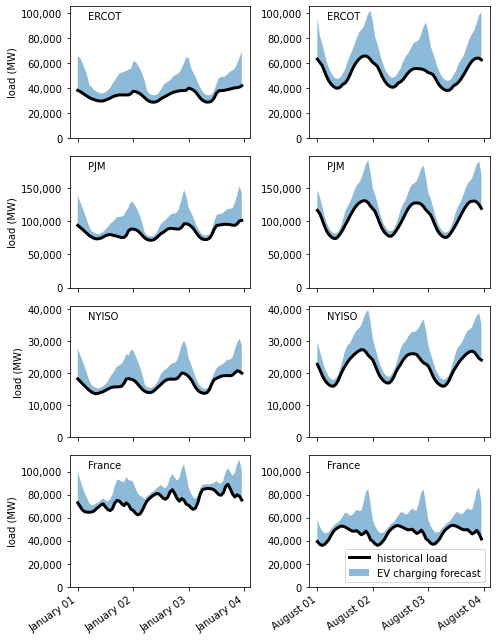

In [9]:
def get_dts(region, length):
    dts, dts2 = [], []
    if region == 'FR':
        yr = 2017
    else:
        yr = 2019
    for i in range(length):
        if i == 0:
            dts.append(datetime(year=yr, month=1, day=1, hour=0))
            dts2.append(datetime(year=yr, month=8, day=1, hour=0))
        else:
            dts.append(dts[-1] + timedelta(hours=1))
            dts2.append(dts2[-1] + timedelta(hours=1))
    return dts, dts2

def plotting(norms):
    
    fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(7,9))
    
    shift = 5000+4000-240
    length = 3*24
    other = 5000
    
    dts, dts2 = get_dts('ERCOT', length) # Kludge, FR is 2017, but with sharex and not showing year it is the same
    for i, region in enumerate(['ERCOT', 'PJM', 'NYISO', 'FR']):
        norm = norms[region]
        info = return_file_info_map(region)
        dfA = pd.read_csv('../../'+info['demand'][0].replace('.csv', '_expDT.csv'))
        dfB = pd.read_csv('../../'+info['demand'][0].replace('.csv', '_expDT_plusEVX.csv'))
    
        idx_tgt = dfA.loc[(dfA['year']==2017) & (dfA['month']==1) & (dfA['day']==1) & (dfA['hour']==1) ].index[0]
        idx_tgt2 = dfA.loc[(dfA['year']==2017) & (dfA['month']==8) & (dfA['day']==1) & (dfA['hour']==1) ].index[0]
    
        

        axs[i][0].plot(dts, dfA.loc[idx_tgt:idx_tgt+length-1, 'demand (MW)']*norm, label='historical load', lw=3, c='k')
        axs[i][0].fill_between(dts, dfA.loc[idx_tgt:idx_tgt+length-1, 'demand (MW)']*norm, 
                        dfB.loc[idx_tgt:idx_tgt+length-1, 'demand (MW)']*norm, label='EV charging forecast', alpha=0.5)
    
    
    
        axs[i][1].plot(dts2, dfA.loc[idx_tgt2:idx_tgt2+length-1, 'demand (MW)']*norm, label='historical load', lw=3, c='k')
        axs[i][1].fill_between(dts2, dfA.loc[idx_tgt2:idx_tgt2+length-1, 'demand (MW)']*norm, 
                        dfB.loc[idx_tgt2:idx_tgt2+length-1, 'demand (MW)']*norm, label='EV charging forecast', alpha=0.5)
        
        axs[i][0].sharey(axs[i][1])
        axs[i][0].set_ylim(0, axs[i][0].get_ylim()[1])
        axs[i][0].set_ylabel('load (MW)')
        axs[i][0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        if i > 0:
            axs[i][0].sharex(axs[0][0])
            axs[i][1].sharex(axs[0][1])
        
        title = region if region != 'FR' else 'France'
        axs[i][0].text(.1, .9, title, transform=axs[i][0].transAxes)
        axs[i][1].text(.1, .9, title, transform=axs[i][1].transAxes)

    axs[3][0].xaxis.set_major_locator(mdates.DayLocator())
    axs[3][1].xaxis.set_major_locator(mdates.DayLocator())
    axs[3][0].xaxis.set_major_formatter(mdates.DateFormatter('%B %d'))
    axs[3][1].xaxis.set_major_formatter(mdates.DateFormatter('%B %d'))
    
    
    fig.autofmt_xdate(rotation=35)
    
    plt.legend(loc='lower right')
    
    
    plt.tight_layout()
    plt.savefig(f'ALL_ev.pdf')

norms = {}
for k, v in ds.items():
    print(k)
    
    # Make leap year profile where Feb 28 is copied to Feb 29
    # (31 days Jan + 28 days Feb) * 24 hrs
    first = (31 + 28) * 24
    #print(first)
    v_leap = v[:first]
    #print(len(v_leap))
    v_leap = np.append(v_leap, v[first-24:first])
    #print(len(v_leap))
    v_leap = np.append(v_leap, v[first:])
    #print(len(v_leap))
    
    info = return_file_info_map(k)
    orig = pd.read_csv('../../'+info['demand'][0])
    tgt_yr = info['years'][-1]
    orig = orig.loc[ orig['year'] == tgt_yr ]
    norm_d = np.sum(orig['demand (MW)'])/len(orig.index)
    norm_ev = np.sum(v/len(v))
    # Alther the norm_ev for France to reduce the PJM profile (which is 40% the size of demand to 25%)
    if k == 'FR':
        norm_ev = norm_ev * 0.25/0.41
    print(tgt_yr, len(orig.index), norm_d, norm_ev, norm_ev/norm_d)
    
    v_norm = v / np.mean(v)
    v_leap_norm = v_leap / np.mean(v_leap)
    
    # Drop out-of-range years
    dt = pd.read_csv('../../'+info['demand'][0].replace('.csv', '_expDT.csv'))
    dt = dt.loc[ (dt['year'] >= info['years'][0]) & (dt['year'] <= info['years'][-1]) ]
    
    for yr in info['years']:
        #print(yr)
        #print(np.mean(dt.loc[ dt['year'] == yr, 'demand (MW)']))
        if calendar.isleap(yr):
            #print(f"is leap {yr}")
            dt.loc[ dt['year'] == yr, 'demand (MW)'] += v_leap_norm * (norm_ev/norm_d)
        else:
            dt.loc[ dt['year'] == yr, 'demand (MW)'] += v_norm * (norm_ev/norm_d)
        #print(np.mean(dt.loc[ dt['year'] == yr, 'demand (MW)']))
    print(np.sum(dt['demand (MW)'])/len(dt.index))
    #dt['demand (MW)'] = dt['demand (MW)'] / (np.sum(dt['demand (MW)'])/len(dt.index))
    print(np.sum(dt['demand (MW)'])/len(dt.index))
    dt.to_csv('../../'+info['demand'][0].replace('.csv', '_expDT_plusEVX.csv'), index=False)
    #print(dem.head())
    norms[k] = norm_d

    
plotting(norms)
